#### VQE CLass

In [46]:
import numpy as np
cliche_1_pauli = ['IIII', 'ZIII', 'IZII', 'IIZI', 'IIIZ', 'ZZII', 'ZIZI', 'ZIIZ', 'IZZI', 'IZIZ', 'IIZZ']
cliche_1_coeffs = [-0.09706627+0.j,  0.17141283+0.j,  0.17141283+0.j, -0.22343154+0.j, -0.22343154+0.j,  0.16868898+0.j,  0.12062523+0.j,  0.16592785+0.j, 0.16592785+0.j,  0.12062523+0.j,  0.17441288+0.j]

eigen_vals_1 = [
    np.kron(np.kron(np.kron([1,1], [1,1]), [1,1]), [1,1]),
    np.kron(np.kron(np.kron([1,1], [1,1]), [1,1]), [1,-1]),
    np.kron(np.kron(np.kron([1,1], [1,1]), [1,-1]), [1,1]),
    np.kron(np.kron(np.kron([1,1], [1,-1]), [1,1]), [1,1]),
    np.kron(np.kron(np.kron([1,-1], [1,1]), [1,1]), [1,1]),
    np.kron(np.kron(np.kron([1,1], [1,1]), [1,-1]), [1,-1]),
    np.kron(np.kron(np.kron([1,1], [1,-1]), [1,1]), [1,-1]),
    np.kron(np.kron(np.kron([1,-1], [1,1]), [1,1]), [1,-1]),
    np.kron(np.kron(np.kron([1,1], [1,-1]), [1,-1]), [1,1]),
    np.kron(np.kron(np.kron([1,-1], [1,1]), [1,-1]), [1,1]),
    np.kron(np.kron(np.kron([1,-1], [1,-1]), [1,1]), [1,1])
]
print(eigen_vals_1)

[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), array([ 1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1]), array([ 1,  1, -1, -1,  1,  1, -1, -1,  1,  1, -1, -1,  1,  1, -1, -1]), array([ 1,  1,  1,  1, -1, -1, -1, -1,  1,  1,  1,  1, -1, -1, -1, -1]), array([ 1,  1,  1,  1,  1,  1,  1,  1, -1, -1, -1, -1, -1, -1, -1, -1]), array([ 1, -1, -1,  1,  1, -1, -1,  1,  1, -1, -1,  1,  1, -1, -1,  1]), array([ 1, -1,  1, -1, -1,  1, -1,  1,  1, -1,  1, -1, -1,  1, -1,  1]), array([ 1, -1,  1, -1,  1, -1,  1, -1, -1,  1, -1,  1, -1,  1, -1,  1]), array([ 1,  1, -1, -1, -1, -1,  1,  1,  1,  1, -1, -1, -1, -1,  1,  1]), array([ 1,  1, -1, -1,  1,  1, -1, -1, -1, -1,  1,  1, -1, -1,  1,  1]), array([ 1,  1,  1,  1, -1, -1, -1, -1, -1, -1, -1, -1,  1,  1,  1,  1])]


In [47]:
# a = SparsePauliOp(['XXYY'], [-0.04530262+0.j])
# print(type(a.coeffs[0]))

In [48]:
import logging
from collections.abc import Callable
from typing import Any
from numpy import ndarray
from time import time
from qiskit.circuit import QuantumCircuit
from qiskit.primitives import BaseEstimator
from qiskit_algorithms.gradients import BaseEstimatorGradient
from qiskit_algorithms.minimum_eigensolvers import VQE, VQEResult
from qiskit_algorithms.optimizers import Minimizer, Optimizer
from qiskit.quantum_info.operators.base_operator import BaseOperator
from qiskit_algorithms.exceptions import AlgorithmError
from qiskit_algorithms.list_or_dict import ListOrDict
from qiskit_algorithms.utils import validate_bounds, validate_initial_point
from qiskit_algorithms.observables_evaluator import estimate_observables
from qiskit_algorithms.utils.set_batching import _set_default_batchsize
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.quantum_info import SparsePauliOp
from qiskit_ibm_runtime import SamplerV2
import numpy as np

logger = logging.getLogger(__name__)

# def get_probability_distribution(counts, NUM_SHOTS):

#     for k in {'00', '01', '10', '11'}:
#         if k not in counts.keys():
#             counts[k] = 0
#     sorted_counts = sorted(counts.items())

#     output_distr = [ v[1] / NUM_SHOTS for v in sorted_counts]
#     if len(output_distr) == 1:
#         output_distr.append(1-output_distr[0])
#     return output_distr

def get_probability_distribution(counts, NUM_SHOTS):

    # All possible 4-qubit measurement outcomes
    all_possible_outcomes = ['0000', '0001', '0010', '0011',
                             '0100', '0101', '0110', '0111',
                             '1000', '1001', '1010', '1011',
                             '1100', '1101', '1110', '1111']
    
    # Ensure all possible outcomes are in counts
    for k in all_possible_outcomes:
        if k not in counts.keys():
            counts[k] = 0
            
    # Sort counts by outcome
    sorted_counts = sorted(counts.items())
    
    # Calculate the probability distribution
    output_distr = [v[1] / NUM_SHOTS for v in sorted_counts]
    
    return output_distr

class SamplerBasedVQE(VQE):
    def __init__(self, estimator: BaseEstimator, ansatz: QuantumCircuit, optimizer: Optimizer | Minimizer, *, gradient: BaseEstimatorGradient | None = None, initial_point: ndarray | None = None, callback: Callable[[int, ndarray, float, dict[str, Any]], None] | None = None) -> None:
        super().__init__(estimator, ansatz, optimizer, gradient=gradient, initial_point=initial_point, callback=callback)
    
    def test_method():
        print("A")

    def _get_evaluate_energy_sampler(
            self, 
            ansatz: QuantumCircuit, 
            operator: BaseOperator
            ) -> Callable[[ndarray], ndarray | float]:
        
        num_parameters = ansatz.num_parameters
        eval_count = 0
        
        def evaluate_energy_sampler(parameters: np.ndarray) -> np.ndarray | float:
            nonlocal eval_count

            # handle broadcasting: ensure parameters is of shape [array, array, ...]
            parameters = np.reshape(parameters, (-1, num_parameters)).tolist()
            batch_size = len(parameters)

            ## =================================================

            try:
                print("*** *** BATCH SIZE:", batch_size)
                print("*** *** ANSATZ:", ansatz)
                print("*** *** OPERATORS:", operator)
                print("*** *** PARAMETERS:", parameters)

                job = self.estimator.run(batch_size * [ansatz], batch_size * [operator], parameters)
                estimator_result = job.result()

                print("\n*** *** ESTIMATOR RESULT:", estimator_result)

            except Exception as exc:
                raise AlgorithmError("The primitive job to evaluate the energy failed!") from exc

            values = estimator_result.values
            print("ESTIMATOR RESULT VALUES", values)

            if self.callback is not None:
                metadata = estimator_result.metadata
                for params, value, meta in zip(parameters, values, metadata):
                    eval_count += 1
                    self.callback(eval_count, params, value, meta)

            energy = values[0] if len(values) == 1 else values
            print("ESTIMATOR RESULT ENERGY", energy)





            # # ==============================================

            sampler = SamplerV2(backend=AerSimulator())
            shots1, shots2, shots3, shots4, shots5 = [1000, 
                                                      1000, 
                                                      1000, 
                                                      1000, 
                                                      1000]
            observables = [
                [SparsePauliOp(['IIII', 'ZIII', 'IZII', 'IIZI', 'IIIZ', 'ZZII', 'ZIZI', 'ZIIZ', 'IZZI', 'IZIZ', 'IIZZ'], [-0.09706627+0.j,  0.17141283+0.j,  0.17141283+0.j, -0.22343154+0.j, -0.22343154+0.j,  0.16868898+0.j,  0.12062523+0.j,  0.16592785+0.j, 0.16592785+0.j,  0.12062523+0.j,  0.17441288+0.j])],
                [SparsePauliOp(['XXYY'], [-0.04530262+0.j])],
                [SparsePauliOp(['XYYX'], [ 0.04530262+0.j])],
                [SparsePauliOp(['YXXY'], [ 0.04530262+0.j])],
                [SparsePauliOp(['YYXX'], [-0.04530262+0.j])]
            ]
            print("\nObservables:", observables)

            
            # Initialize the total expectation value
            total_expectation_value = 0

            ## CLIQUE 1

            # clique_1 = SparsePauliOp(['IIII', 'ZIII', 'IZII', 'IIZI', 'IIIZ', 'ZZII', 'ZIZI', 'ZIIZ', 'IZZI', 'IZIZ', 'IIZZ'], [-0.09706627+0.j,  0.17141283+0.j,  0.17141283+0.j, -0.22343154+0.j, -0.22343154+0.j,  0.16868898+0.j,  0.12062523+0.j,  0.16592785+0.j, 0.16592785+0.j,  0.12062523+0.j,  0.17441288+0.j])
            clique_1_pauli = ['IIII', 'ZIII', 'IZII', 'IIZI', 'IIIZ', 'ZZII', 'ZIZI', 'ZIIZ', 'IZZI', 'IZIZ', 'IIZZ']
            clique_1_coeffs = [-0.09706627+0.j,  0.17141283+0.j,  0.17141283+0.j, -0.22343154+0.j, -0.22343154+0.j,  0.16868898+0.j,  0.12062523+0.j,  0.16592785+0.j, 0.16592785+0.j,  0.12062523+0.j,  0.17441288+0.j]
            
            ansatz_1 = ansatz.copy()
            ansatz_1.measure_all()

            job_1 = sampler.run([(ansatz_1, parameters)], shots=shots1)
            counts_1 = job_1.result()[0].data.meas.get_counts()
            prob_dist_1 = get_probability_distribution(counts_1, sum(counts_1.values()))

            exp_vals_1 = [x * y * z for x, y, z in zip(eigen_vals_1, prob_dist_1, clique_1_coeffs)]
            total_expectation_value += np.sum(exp_vals_1)



            ## CLIQUE 2
            clique_2 = SparsePauliOp(['XXYY'], [-0.04530262+0.j])
            ansatz_2 = ansatz.copy()
            ansatz_2.sdg([0,1])
            ansatz_2.h([0,1,2,3]) 
            ansatz_2.measure_all()

            job_2 = sampler.run([(ansatz_2, parameters)], shots=shots2)
            counts_2 = job_2.result()[0].data.meas.get_counts()
            prob_dist_2 = get_probability_distribution(counts_2, sum(counts_2.values()))

            eigen_vals_2 = np.kron(np.kron(np.kron([1,-1], [1,-1]), [1,-1]), [1,-1])
            print("eigen vals 2:", eigen_vals_2)
            print("prob dist 2:", prob_dist_2)
            exp_vals_2 = np.dot(eigen_vals_2, prob_dist_2)
            total_expectation_value += exp_vals_2*clique_2.coeffs[0]


            ## CLIQUE 3
            clique_3 = SparsePauliOp(['XYYX'], [0.04530262+0.j])
            ansatz_3 = ansatz.copy()
            ansatz_3.sdg([1,2])
            ansatz_3.h([0,1,2,3]) 
            ansatz_3.measure_all()

            job_3 = sampler.run([(ansatz_3, parameters)], shots=shots3)
            counts_3 = job_3.result()[0].data.meas.get_counts()
            prob_dist_3 = get_probability_distribution(counts_3, sum(counts_3.values()))
            
            eigen_vals_3 = np.kron(np.kron(np.kron([1,-1], [1,-1]), [1,-1]), [1,-1])
            exp_vals_3 = np.dot(eigen_vals_3, prob_dist_3)
            total_expectation_value += exp_vals_3*clique_3.coeffs[0]


            ## CLIQUE 4
            clique_4 = SparsePauliOp(['YXXY'], [0.04530262+0.j])
            ansatz_4 = ansatz.copy()
            ansatz_4.sdg([0,3])
            ansatz_4.h([0,1,2,3]) 
            ansatz_4.measure_all()

            job_4 = sampler.run([(ansatz_4, parameters)], shots=shots4)
            counts_4 = job_4.result()[0].data.meas.get_counts()
            prob_dist_4 = get_probability_distribution(counts_4, sum(counts_4.values()))
            
            eigen_vals_4 = np.kron(np.kron(np.kron([1,-1], [1,-1]), [1,-1]), [1,-1])
            exp_vals_4 = np.dot(eigen_vals_4, prob_dist_4)
            total_expectation_value += exp_vals_4*clique_4.coeffs[0]


            ## CLIQUE 5
            clique_5 = SparsePauliOp(['YYXX'], [-0.04530262+0.j])
            ansatz_5 = ansatz.copy()
            ansatz_5.sdg([2,3])
            ansatz_5.h([0,1,2,3]) 
            ansatz_5.measure_all()

            job_5 = sampler.run([(ansatz_5, parameters)], shots=shots5)
            counts_5 = job_5.result()[0].data.meas.get_counts()
            prob_dist_5 = get_probability_distribution(counts_5, sum(counts_5.values()))
            
            eigen_vals_5 = np.kron(np.kron(np.kron([1,-1], [1,-1]), [1,-1]), [1,-1])
            exp_vals_5 = np.dot(eigen_vals_5, prob_dist_5)
            total_expectation_value += exp_vals_5*clique_5.coeffs[0]

            total_expectation_value -= 0.7
            print("Total Expectation Value:", total_expectation_value, "\n")

            return total_expectation_value

        return evaluate_energy_sampler

    def compute_minimum_eigenvalue_sampler(
        self,
        operator: BaseOperator,
        aux_operators: ListOrDict[BaseOperator] | None = None,
    ) -> VQEResult:
        self._check_operator_ansatz(operator)

        initial_point = validate_initial_point(self.initial_point, self.ansatz)

        bounds = validate_bounds(self.ansatz)

        start_time = time()

        evaluate_energy = self._get_evaluate_energy_sampler(self.ansatz, operator)

        if self.gradient is not None:
            evaluate_gradient = self._get_evaluate_gradient(self.ansatz, operator)
        else:
            evaluate_gradient = None

        # perform optimization
        if callable(self.optimizer):
            optimizer_result = self.optimizer(
                fun=evaluate_energy,  # type: ignore[arg-type]
                x0=initial_point,
                jac=evaluate_gradient,
                bounds=bounds,
            )
        else:
            # we always want to submit as many estimations per job as possible for minimal
            # overhead on the hardware
            was_updated = _set_default_batchsize(self.optimizer)

            optimizer_result = self.optimizer.minimize(
                fun=evaluate_energy,  # type: ignore[arg-type]
                x0=initial_point,
                jac=evaluate_gradient,  # type: ignore[arg-type]
                bounds=bounds,
            )

            # reset to original value
            if was_updated:
                self.optimizer.set_max_evals_grouped(None)

        optimizer_time = time() - start_time

        logger.info(
            "Optimization complete in %s seconds.\nFound optimal point %s",
            optimizer_time,
            optimizer_result.x,
        )

        if aux_operators is not None:
            aux_operators_evaluated = estimate_observables(
                self.estimator,
                self.ansatz,
                aux_operators,
                optimizer_result.x,  # type: ignore[arg-type]
            )
        else:
            aux_operators_evaluated = None

        return self._build_vqe_result(
            self.ansatz,
            optimizer_result,
            aux_operators_evaluated,  # type: ignore[arg-type]
            optimizer_time,
        )
    

In [49]:
from src.helper import *

class AdaptVQEData:
    def __init__(self, initial_energy, pool, sparse_pool, ref_determinant, backend, shots, prev_data = None):
        self.pool = pool
        self.sparse_pool = sparse_pool
        self.shots = shots
        self.backend = backend

        if prev_data is not None:
            self.initial_energy = initial_energy
            self.evolution = copy.deepcopy(prev_data.evolution)

            if not prev_data.result:
                raise ValueError("Previous data does not supply final results")
            
            self.current = copy.deepcopy(prev_data.result)
            self.iteration_count = prev_data.iteration_count

            if prev_data is not None:
                assert(len(self.sparse_pool) == len(prev_data.sparse_pool))

        else:
            self.initial_energy = initial_energy
            self.evolution = {}
            self.evolution["energies"] = []
            self.evolution["total norm"] = []
            self.evolution["selected_grad"] = []
            self.evolution["coefficients"] = []
            self.evolution["energy change"] = []
            self.evolution["indices"] = []

            self.current = {}
            self.current["ansatz"] = []
            self.current["coefficients"] = []
            self.current["indices"] = []
            self.current["ansatz performances"] = []
            self.current["performances"] = []
            self.current["energy"] = None
            self.current["state"] = None
            self.current["total norm"] = None

            self.iteration_count = 0
        
        self.closed = False
        self.success = False

        self.result = {}
            

    def processIteration(self, operator_idx, operator, energy, total_norm, selected_grad, coefficients):
        
        self.current["coefficients"] = copy.deepcopy(coefficients)
        
        if self.iteration_count == 0:
            prev_energy = self.initial_energy
        else:
            prev_energy = self.current['energy']

        energy_change = energy - prev_energy
        # print("Energy Change:", energy_change)
        performance = np.abs(energy_change/selected_grad)

        self.current['ansatz performances'].append(performance)
        self.current['performances'].append(performance)

        ansatz_performance = np.average(self.current['ansatz performances'])
        # print("Ansatz Performance:", ansatz_performance)
        
        self.current['ansatz'].append(operator)
        self.current['energy'] = energy
        self.current['indices'].append(operator_idx)
        self.current['total norm'] = total_norm

        coefficients_copy = copy.deepcopy(self.current['coefficients'])
        indices_copy = copy.deepcopy(self.current['indices'])

        self.evolution['energies'].append(energy)
        self.evolution['energy change'].append(energy_change)
        self.evolution['total norm'].append(total_norm)
        self.evolution['selected_grad'].append(selected_grad)
        self.evolution['indices'].append(indices_copy)
        self.evolution['coefficients'].append(coefficients_copy)
        self.iteration_count += 1
        

    def close(self, success):
        # print("CLOSE")
        # print("self.current:", self.current)
        self.result = self.current
        self.closed = True
        self.success = success

    def plot(self, plotGradient = True, detailedTitle = True):
        iteration_number = self.iteration_count
        iteration_labels = [ iterationLable for iterationLable in range(0, self.iteration_count+1)]

        gradient_norms = self.evolution['total norm']
        energies = [self.initial_energy] + self.evolution['energies']


        fig, ax1 = plt.subplots(figsize=[8,8])
        ax1.plot(iteration_labels, energies, '--o', color='navy')
        
        # exact_energy = self.molecule.fci_energy
        exact_energy = -1.13728
        min_accuracy = exact_energy - chemicalAccuracy
        max_accuracy = exact_energy + chemicalAccuracy
        l = ax1.axhspan(min_accuracy, max_accuracy, alpha=0.3, color='cornflowerblue')

        ax1.set_xlabel("Iteration Number")
        ax1.set_ylabel("Energy (au)", color='navy')

        plt.xticks(range(1, 1+ self.iteration_count))

        if plotGradient:
            color2 = 'r'
            ax2 = ax1.twinx()
            ax2.plot(iteration_labels[1:], gradient_norms, '--o', color='maroon')
            ax2.tick_params(axis='y', labelcolor='maroon')
            ax2.set_ylabel("Total Gradient Norm", color='maroon')

        
        


class AdaptVQE:
    def __init__(self, pool, molecule, backend, shots = 1024, max_iter = 50, verbose = False, threshold = 0.1, ref_determinant = None):

        # Init . . .
        self.pool = pool.copy()
        self.molecule = molecule
        self.backend = backend
        self.shots = shots
        self.max_iter = max_iter
        self.verbose = verbose
        self.threshold = threshold
        self.ref_determinant = ref_determinant

        # Hamiltonian and Refernce Value
        self.sparse_hamiltonian = get_sparse_operator(self.molecule.get_molecular_hamiltonian(), self.molecule.get_molecular_hamiltonian().n_qubits)

        self.qubit_hamiltonian = jordan_wigner(self.molecule.get_molecular_hamiltonian())
        dict_hamiltonian = convertHamiltonian(self.qubit_hamiltonian)
        self.hamiltonian = SparsePauliOp.from_list(list(dict_hamiltonian.items()))
        self.ref_value = NumPyMinimumEigensolver().compute_minimum_eigenvalue(operator=self.hamiltonian).eigenvalue.real
        print(f"Reference value: {self.ref_value:.5f}")

        # Lists
        self.sparse_pool = []
        self.ansatz = []
        self.coefficients = []
        self.indices = []


    def prepare(self, sparse_pool = None, prev_data = None):

        # Sparse Pool
        if sparse_pool is None:
            print("Sparse poll was not provided. Obtaining it . . .")
            for operator in self.pool:
                self.sparse_pool.append(get_sparse_operator(operator, self.molecule.get_molecular_hamiltonian().n_qubits))
        else:
            self.sparse_pool = sparse_pool
        # print("Sparse Pool: ", self.sparse_pool)

        # Reference State Ket
        if self.ref_determinant is None:
            hartree_fock_ket = getHartreeFockKet(self.molecule.n_electrons, self.molecule.get_molecular_hamiltonian().n_qubits)
            print("\nHartree Fock Kate:", hartree_fock_ket)
            self.ref_determinant = hartree_fock_ket

        hartree_fock_vect = fromKettoVector(self.ref_determinant)
        print("Hartree Fock Vector:", hartree_fock_vect)
        self.reference_state = hartree_fock_vect


        # Reference State Vector
        self.sparse_reference_state = scipy.sparse.csc_matrix(self.reference_state, dtype=complex).transpose()
        print("Sparse Reference State:", self.sparse_reference_state)


        # Initial Energy
        initial_energy = self.calculateEnergy([],[])
        print("\nInitial Energy:", initial_energy)


        # Initialize Data
        self.data = AdaptVQEData(initial_energy, self.pool, self.sparse_pool, self.ref_determinant, self.backend, self.shots, prev_data)
        # print("Data Current['state']:", self.data.current['state'])
        if self.data.current['state'] is None:
            # print("Initially None, then Data Current['state']:", self.sparse_reference_state)
            self.data.current['state'] = self.sparse_reference_state
            
        # print("Data Current['state'] Updated:", self.data.current['state'], '\n')

        print("ADAPT-VQE Configurations:")
        self.printSettings()
    

    def printSettings(self):
        print("> Convergence threshold (gradient norm): ", self.threshold)
        print("> Maximum number of iterations: ", self.max_iter)
        print("> Backend: ",self.backend)      
  

    def computeState(self):
        # print("\n=== Compute State ===\n")
        state = self.sparse_reference_state # State = HF

        for (i, operator_idx) in enumerate(self.data.current['indices']):
            # print(i, operator_idx)
            # print("Compute State -> Current Data:", self.data.current['indices'])
            coeff = self.data.current['coefficients'][i]
            sparse_operator = self.sparse_pool[operator_idx].multiply(coeff)
            exp_operator = scipy.sparse.linalg.expm(sparse_operator)
            state = exp_operator * state
        return state


    def calculateGradient(self, operator_idx):

        sparse_operator = self.sparse_pool[operator_idx]
        # print("\nCalculate Gradient -> Sparse Operator:", sparse_operator)
        # print("\nCalculate Gradient -> Sparse Operator Type:", type(sparse_operator))

        current_state = self.data.current['state']
        # print("\nCalculate Gradient -> Current Data State:", current_state)
        
        # print("sparse operator: >>", sparse_operator)
        # print("current state: >>", current_state)

        test_state = sparse_operator * current_state
        bra = current_state.transpose().conj()
        gradient = 2*(np.abs(bra*self.sparse_hamiltonian*test_state)[0,0].real)
        # print("\nCalculate Gradient -> Gradient Value:", gradient)
        return gradient
    

    def selectOperator(self):
        selected_gradient = 0
        selected_idx = None
        total_norm = 0

        print("\nNon-zero Gradients (calculated, tolerance E-5)")

        # First, iterate through all operator in self pool
        # print("Number of Operator inside the pool:", len(self.pool))
        for operator_idx in range(len(self.pool)):
            # print("\nSelect Operator -> current operator idx:", operator_idx)

            gradient = self.calculateGradient(operator_idx)
            # print("\n # # # Select Operator -> Calculated gradient of operator", operator_idx, ": ", gradient)
            
            total_norm += gradient**2

            if gradient > 10**-5:
                print("Select Operator -> {}: {}".format(operator_idx, gradient))

            if gradient > selected_gradient:
                selected_idx = operator_idx
                selected_gradient =  gradient

        total_norm = np.sqrt(total_norm)
        # print("Select Operator -> Total gradient norm: {}".format(total_norm))
        
        return selected_idx, selected_gradient, total_norm
    

    def calculateEnergy(self, coefficients, indices):
        ket = self.sparse_reference_state
        # print("\nCalculate Energy -> Ket:", ket)

        for (coeff, operator_idx) in zip(coefficients, indices):
            # print("Coefficients:", coeff, "Indices:", operator_idx, "operator", self.pool[operator_idx])
            sparse_operator = coeff * self.sparse_pool[operator_idx]
            exp_operator = scipy.sparse.linalg.expm(sparse_operator)
            ket = exp_operator * ket
            
        bra = ket.transpose().conj()
        # print("Calculate Energy -> Bra:", bra)

        energy = ( bra * self.sparse_hamiltonian * ket )[0,0].real
        # print("Calculate Energy -> Energy:", energy)

        return energy
        

    def callback(self, nfev, parameters, energy, stddev):
        # print("**Callback**")
        self.opt_evolution['nfev'].append(nfev)
        self.opt_evolution['parameters'].append(parameters.copy())
        self.opt_evolution['energy'].append(energy)
        self.opt_evolution['stddev'].append(stddev)
        # print("Opt Evolution", self.opt_evolution, '\n')


    def optimizeCircuit(self, initial_coeff, indices):

        self.opt_evolution = {
            'nfev':[],
            'parameters':[],
            'energy':[],
            'stddev':[]
        }
        parameters = ParameterVector("Params", len(indices))


        # Ansatz Initiation
        ansatz = QuantumCircuit(self.molecule.get_molecular_hamiltonian().n_qubits)
        print("\nOptimize Circuit -> Ansatz:", ansatz)


        # Add X gate based on reference state
        print("Optimize Circuit -> Ref Determinant:", self.ref_determinant)
        for i, state in enumerate(self.ref_determinant):
            if state == 1:
                ansatz.x(self.molecule.get_molecular_hamiltonian().n_qubits - 1 -i)
        print("Optimize Circuit -> Updated Ansatz:", ansatz)


        for i, op in enumerate(indices):
            pauliToCircuit(self.pool[op], parameters[i], ansatz, self.molecule.get_molecular_hamiltonian().n_qubits)
        print("Optimize Circuit -> Updated Ansatz by Pauli to Circuit:", ansatz)


        # vqe = VQE(
        #     estimator=Estimator(),
        #     ansatz=ansatz,
        #     optimizer=COBYLA(rhobeg=0.1),
        #     callback = self.callback,
        #     initial_point=initial_coeff 
            # )
        vqe = SamplerBasedVQE(
            estimator=Estimator(),
            ansatz=ansatz,
            optimizer=COBYLA(rhobeg=0.1),
            callback = self.callback,
            initial_point=initial_coeff 
            )
        
        
        result = vqe.compute_minimum_eigenvalue_sampler(operator=self.hamiltonian)
        # result = vqe.(operator=self.hamiltonian)
        print("OPT EVOLUTION AFTER VQE: Energy ", self.opt_evolution['energy'])
        print("OPT EVOLUTION AFTER VQE: Parameters", self.opt_evolution['parameters'])
        # print("\nOptimize Circuit -> VQE Result:", result)
        # result = 1


    def run(self):

        while self.data.iteration_count < self.max_iter:
            print("==================SELF.DATA.RESULT: ", self.data.result)
            print("\n*** Adapt Iteration {} ***\n".format(self.data.iteration_count + 1))

            max_idx, max_grad, total_norm = self.selectOperator()
            max_operator = self.pool[max_idx]

            print("\nMAIN RUN -> max id:", max_idx, "max grad:", max_grad, "total norm:", total_norm, "max operator:", max_operator)

            if total_norm < self.threshold:
                print("Convergence condition achieved")
                self.data.close(success = True)
            
                if self.data.result['energy'] is None:
                    print("The chosen threshold was too large")
                    return
                
                print("Final Energy:", self.data.result['energy'])
                error = self.data.result['energy'] - self.molecule.fci_energy
                print("Error", error)
                return 
            
            print("Selected: {}, index {}".format(self.pool[max_idx], max_idx))
            print("(gradient: {})".format(max_grad))

            new_indices = self.data.current['indices'].copy()
            new_indices.append(max_idx)

            new_coeffs = copy.deepcopy(self.data.current['coefficients'])
            new_coeffs.append(0)

            print("Optimizing energy with indices {} . . .".format(self.data.current['indices']+[max_idx]))
            indices = self.data.current['indices'] + [max_idx]





            # Optimize Circuit
            
            self.optimizeCircuit(new_coeffs, indices)
            
            print("EVOLUTION PARAMETER:", self.opt_evolution['parameters'])
            optimized_coeffs = list(self.opt_evolution['parameters'][-1])
            print(len(optimized_coeffs))
            
            optimized_energy = self.calculateEnergy(optimized_coeffs, indices)
            print("Optimized Energy: ", optimized_energy)






            



            # print("PROCESS ITERATION -",self.data.iteration_count)
            self.data.processIteration(max_idx, max_operator, optimized_energy, total_norm, max_grad, optimized_coeffs)

            # print("Current ansatz", self.data.current['ansatz'])

            new_state = self.computeState()
            self.data.current['state'] = new_state
            # print("==================SELF.DATA.RESULT: ", self.data.result)
        
        print("\nThe maximum number of iterations ({}) was hit before the convergence criterion was satisfied \n"
              "Current gradient norm is {} > {}".format(self.max_iter, self.data.current['total norm'], self.threshold) 
              )
        self.data.close(success=False)


In [50]:
def create_h2(r):
    """
    Arguments:
        r (float): interatomic distance (angstrom)
    Returns:
        h2 (PyscfMolecularData): the linear H2 molecule at interatomic distance r, in the minimal STO-3G basis set
    """

    geometry = [['H', [0, 0, 0]], ['H', [0, 0, r]]]
    basis = 'sto-3g'
    multiplicity = 1
    charge = 0
    h2 = MolecularData(geometry, basis, multiplicity, charge, description='H2')
    h2 = run_pyscf(h2, run_fci=True, run_ccsd=True)

    return h2

def create_h4(r):
    """
    Arguments:
        r (float): interatomic distance (angstrom)
    Returns:
        h4 (PyscfMolecularData): the linear H4 molecule at interatomic distance r, in the minimal STO-3G basis set
    """

    geometry = [('H', (0, 0, 0)), ('H', (0, 0, r)), ('H', (0, 0, 2 * r)),
                ('H', (0, 0, 3 * r))]
    basis = 'sto-3g'
    multiplicity = 1
    charge = 0
    h4 = MolecularData(geometry, basis, multiplicity, charge, description='H4')
    h4 = run_pyscf(h4, run_fci=True, run_ccsd=True)
    return h4

h2 = create_h2(0.7)

In [51]:
# Import
from src.operator_pool import fermionicPool, qubitPool
# from src.molecular_def import h2, liH
from qiskit_aer import QasmSimulator

fermionic_pool = fermionicPool(2)
qubit_pool = qubitPool(fermionic_pool)

# ADAPTVQE Object Instantiation
adapt_vqe_h2 = AdaptVQE(pool = qubit_pool,
                        molecule = h2, # Openfermion datatype
                        backend = QasmSimulator(),
                        shots = 1024,
                        max_iter = 5,
                        verbose = True,
                        threshold=0.00015,
                        ref_determinant = None
                        )

adapt_vqe_h2.prepare()
adapt_vqe_h2.computeState()

Pool size: 4
Pool Size: 20
Reference value: -1.13619
Sparse poll was not provided. Obtaining it . . .

Hartree Fock Kate: [1, 1, 0, 0]
Hartree Fock Vector: [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
Sparse Reference State:   (12, 0)	(1+0j)

Initial Energy: -1.1173490349902795
ADAPT-VQE Configurations:
> Convergence threshold (gradient norm):  0.00015
> Maximum number of iterations:  5
> Backend:  QasmSimulator('qasm_simulator')


<16x1 sparse matrix of type '<class 'numpy.complex128'>'
	with 1 stored elements in Compressed Sparse Row format>

#### Run

In [52]:
adapt_vqe_h2.run()
data = adapt_vqe_h2.data

==================SELF.DATA.RESULT:  {}

*** Adapt Iteration 1 ***


Non-zero Gradients (calculated, tolerance E-5)
Select Operator -> 8: 0.35800115212281325
Select Operator -> 9: 0.35800115212281325
Select Operator -> 10: 0.35800115212281325
Select Operator -> 11: 0.35800115212281325
Select Operator -> 12: 0.35800115212281325
Select Operator -> 13: 0.35800115212281325
Select Operator -> 14: 0.35800115212281325
Select Operator -> 15: 0.35800115212281325

MAIN RUN -> max id: 8 max grad: 0.35800115212281325 total norm: 1.012580169354552 max operator: 1j [X0 X1 Y2 X3]
Selected: 1j [X0 X1 Y2 X3], index 8
(gradient: 0.35800115212281325)
Optimizing energy with indices [8] . . .

Optimize Circuit -> Ansatz:      
q_3: 
     
q_2: 
     
q_1: 
     
q_0: 
     
Optimize Circuit -> Ref Determinant: [1, 1, 0, 0]
Optimize Circuit -> Updated Ansatz:      ┌───┐
q_3: ┤ X ├
     ├───┤
q_2: ┤ X ├
     └───┘
q_1: ─────
          
q_0: ─────
          
Optimize Circuit -> Updated Ansatz by Pauli to Circ

In [53]:
# evo = np.array(data.evolution['coefficients'][10])
# print(len(evo))

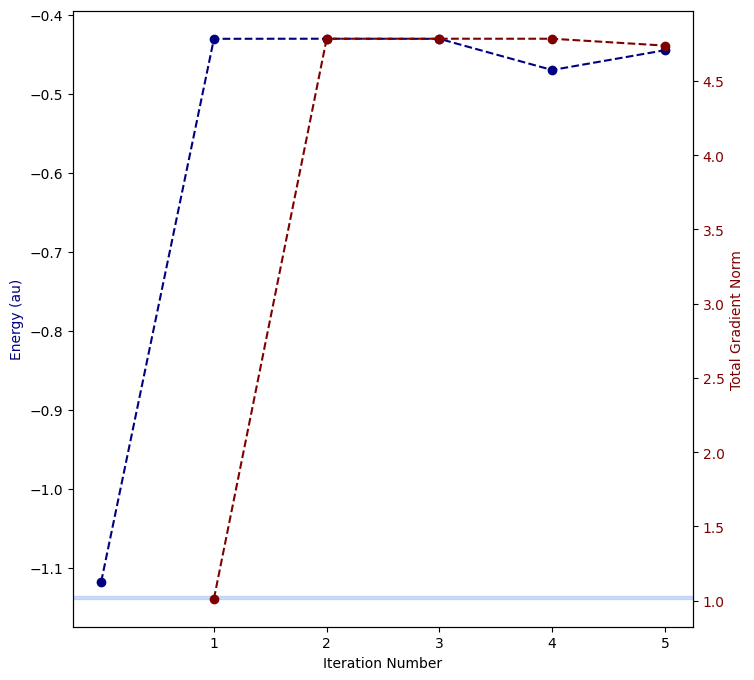

In [54]:
data.plot()

In [55]:
data.result['ansatz']

[1j [X0 X1 Y2 X3],
 1j [X0 X1 Y2 X3],
 1j [X0 X1 Y2 X3],
 1j [X0 X1 Y2 X3],
 1j [X0 X1 Y2 X3]]

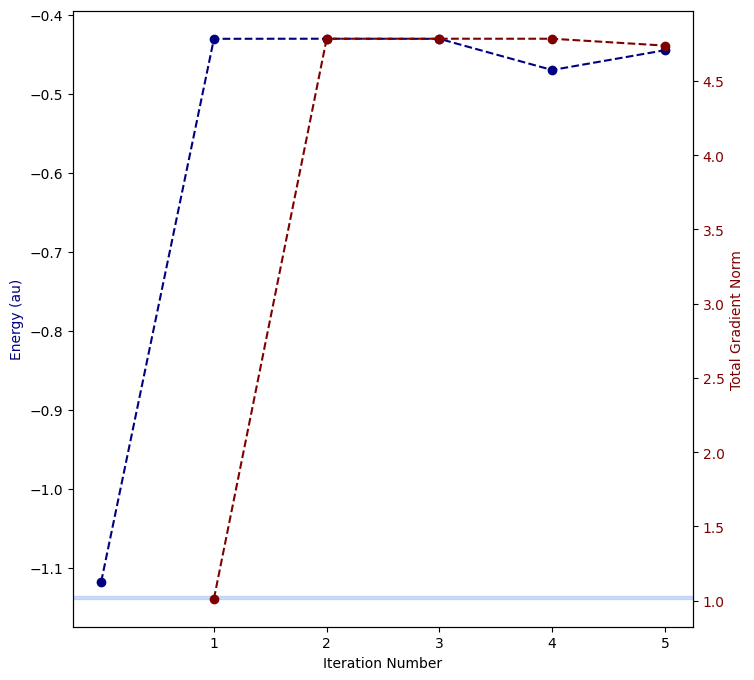

In [56]:
data.plot()

In [57]:
evolution = adapt_vqe_h2.opt_evolution
evolution

{'nfev': [1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30],
 'parameters': [[0.7950895506563297,
   -0.004212407373957014,
   -0.004676636298333003,
   -0.00960369356116685,
   0.0],
  [0.8950895506563297,
   -0.004212407373957014,
   -0.004676636298333003,
   -0.00960369356116685,
   0.0],
  [0.7950895506563297,
   0.09578759262604299,
   -0.004676636298333003,
   -0.00960369356116685,
   0.0],
  [0.7950895506563297,
   -0.004212407373957014,
   0.095323363701667,
   -0.00960369356116685,
   0.0],
  [0.7950895506563297,
   -0.004212407373957014,
   -0.004676636298333003,
   0.09039630643883316,
   0.0],
  [0.7950895506563297,
   -0.004212407373957014,
   -0.004676636298333003,
   -0.00960369356116685,
   0.1],
  [0.7508409914657785,
   -0.04431266414039553,
   -0.061370102761227376,
   -0.05108671780230903,
   -0.03871748929173315],
  [0.7729652710610541,
   -0.02426

In [58]:
print(data.result)

{'ansatz': [1j [X0 X1 Y2 X3], 1j [X0 X1 Y2 X3], 1j [X0 X1 Y2 X3], 1j [X0 X1 Y2 X3], 1j [X0 X1 Y2 X3]], 'coefficients': [0.81960847386716, -0.006394916969428241, -0.0077917788123390425, -0.011821110591923069, -0.0021072506439032226], 'indices': [8, 8, 8, 8, 8], 'ansatz performances': [1.917943262069419, 6.233294297725323e-05, 8.56462190890904e-05, 0.02332115119783339, 0.014945731517380186], 'performances': [1.917943262069419, 6.233294297725323e-05, 8.56462190890904e-05, 0.02332115119783339, 0.014945731517380186], 'energy': -0.4451740693153357, 'state': <16x1 sparse matrix of type '<class 'numpy.complex128'>'
	with 2 stored elements in Compressed Sparse Column format>, 'total norm': 4.7383528156615755}


In [59]:
evolution['parameters']

[[0.7950895506563297,
  -0.004212407373957014,
  -0.004676636298333003,
  -0.00960369356116685,
  0.0],
 [0.8950895506563297,
  -0.004212407373957014,
  -0.004676636298333003,
  -0.00960369356116685,
  0.0],
 [0.7950895506563297,
  0.09578759262604299,
  -0.004676636298333003,
  -0.00960369356116685,
  0.0],
 [0.7950895506563297,
  -0.004212407373957014,
  0.095323363701667,
  -0.00960369356116685,
  0.0],
 [0.7950895506563297,
  -0.004212407373957014,
  -0.004676636298333003,
  0.09039630643883316,
  0.0],
 [0.7950895506563297,
  -0.004212407373957014,
  -0.004676636298333003,
  -0.00960369356116685,
  0.1],
 [0.7508409914657785,
  -0.04431266414039553,
  -0.061370102761227376,
  -0.05108671780230903,
  -0.03871748929173315],
 [0.7729652710610541,
  -0.024262535757176275,
  -0.03302336952978019,
  -0.030345205681737937,
  -0.019358744645866576],
 [0.81960847386716,
  -0.006394916969428241,
  -0.007762253312619831,
  -0.01186146210820599,
  -0.0021072506439032226],
 [0.81960847386716,


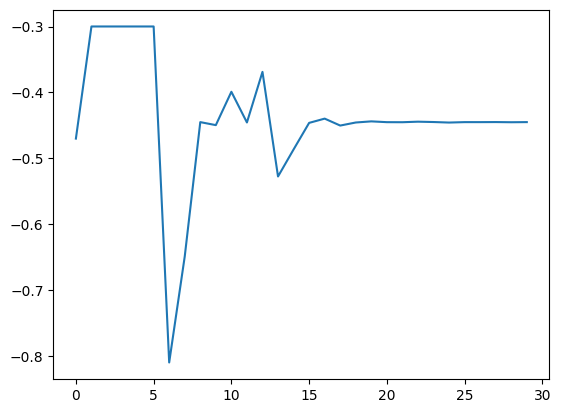

In [60]:
plt.plot(evolution['energy'])

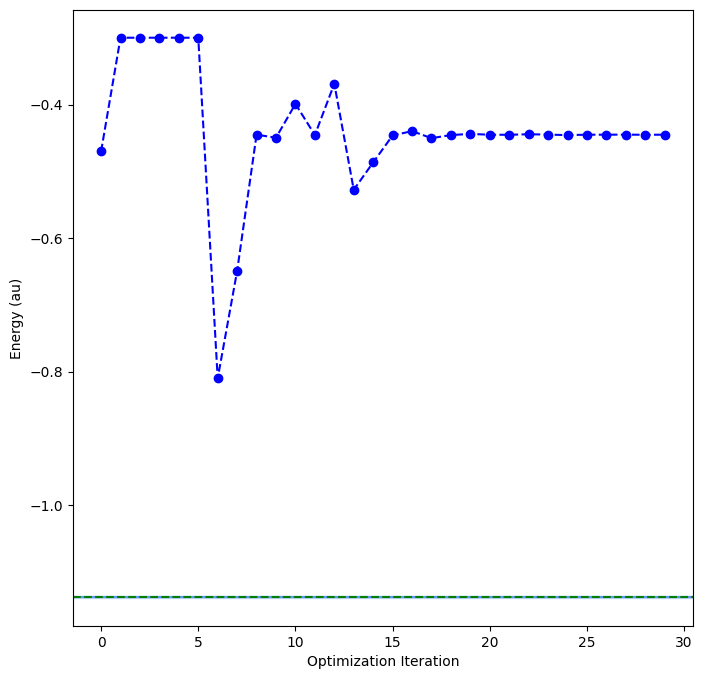

In [61]:
nfev = evolution["nfev"][-1]
energies = []
exact_energy = -1.13728


for i in range(nfev):
  optimized_coefficients = list(evolution["parameters"][i])
  energy = adapt_vqe_h2.calculateEnergy(optimized_coefficients, data.result["indices"])
  energies.append(energy)

fig, ax1 = plt.subplots(figsize=[8,8])

nfev = evolution["nfev"][-1]

color1 = 'b'
ax1.plot(range(nfev), energies, '--o', color = color1)
ax1.set_xlabel("Optimization Iteration")
ax1.set_ylabel("Energy (au)")


minAccuracy = exact_energy - chemicalAccuracy
maxAccuracy = exact_energy + chemicalAccuracy
l = ax1.axhspan(minAccuracy, maxAccuracy, alpha=0.3, color = 'cornflowerblue')
plt.axhline(y = exact_energy, color = 'cornflowerblue' , linestyle = '-')
plt.axhline(-1.13728, color='green', linestyle='--')

In [62]:
adapt_vqe_h2.data.result

{'ansatz': [1j [X0 X1 Y2 X3],
  1j [X0 X1 Y2 X3],
  1j [X0 X1 Y2 X3],
  1j [X0 X1 Y2 X3],
  1j [X0 X1 Y2 X3]],
 'coefficients': [0.81960847386716,
  -0.006394916969428241,
  -0.0077917788123390425,
  -0.011821110591923069,
  -0.0021072506439032226],
 'indices': [8, 8, 8, 8, 8],
 'ansatz performances': [1.917943262069419,
  6.233294297725323e-05,
  8.56462190890904e-05,
  0.02332115119783339,
  0.014945731517380186],
 'performances': [1.917943262069419,
  6.233294297725323e-05,
  8.56462190890904e-05,
  0.02332115119783339,
  0.014945731517380186],
 'energy': -0.4451740693153357,
 'state': <16x1 sparse matrix of type '<class 'numpy.complex128'>'
 	with 2 stored elements in Compressed Sparse Column format>,
 'total norm': 4.7383528156615755}

In [63]:
print(type(adapt_vqe_h2.data))

<class '__main__.AdaptVQEData'>
